# 1. Prepare Data

In [2]:
# sample_number = 5000
# anomaly_ratio   = 0.2
# test_size            = 0.5

# signal_length    = 1024
# Fs                     = 20480
# rotate_fre         = 60
# sigma               = 1
# coeff_type        = [1,1]
# from tools.SimulateDataset import data_prepare
# data_dict = data_prepare(sample_number, anomaly_ratio, test_size, signal_length, rotate_fre, Fs, sigma, coeff_type)
# import joblib
# joblib.dump(data_dict,r'.\data\Simulated_dataset.pkl')

In [3]:
# Ablation study train
# from model.AAU_Net import parse_args, train_AAUNet

# def train():
    
#     # setting paramater
#     opt = parse_args()

#     for dataset in ['Simulated', 'QianPeng', 'SQI']:
#         opt.data_path = r'.\data\{}_dataset.pkl'.format(dataset)

#         for active_type in ['Hard', 'ReLU', 'Soft']:
#             opt.active_type = active_type
#             opt.output_path = r'.\result\{}_{}'.format(dataset, active_type)

#             # train model
#             ACC = train_AAUNet(opt)
    
#     return ACC

# if __name__ == '__main__':
#     ACC = train()

# 2. Visualization

### Check samples

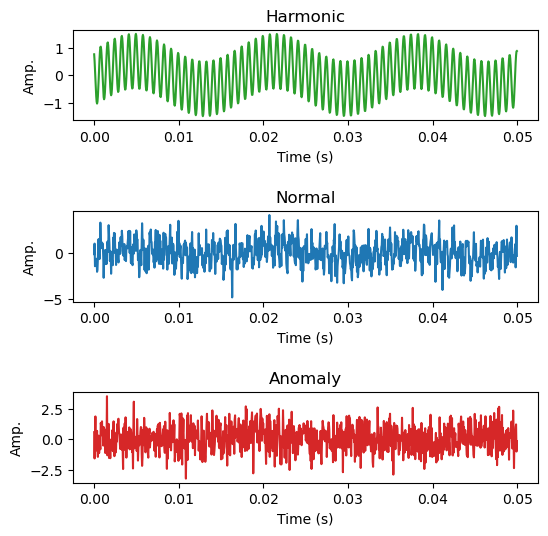

In [5]:
%matplotlib inline
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
data_dict = joblib.load(r'.\data\Simulated_dataset.pkl')

ground_truth      = data_dict['test_gth_1d'][1000,0]
normal_sample   = data_dict['test_1d'][1000,0]
anomaly_sample = data_dict['test_1d'][-1,0]

color_list = ['#2ca02c', '#1f77b4', '#d62728']
x = np.arange(0, 1024/20480, 1/20480)
y_list, title_list, mark_list = [ground_truth, normal_sample, anomaly_sample], ['Harmonic', 'Normal', 'Anomaly'], ['(a)', '(b)', '(c)']

figure = plt.figure(1,figsize=(6,6), dpi=100)
plt.subplots_adjust(hspace=1, wspace=0.2)
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(x, y_list[i], color=color_list[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Amp.')
    plt.title(title_list[i])
plt.show()
figure.savefig(r'.\figure\normal_and_abnormal_samples.pdf',bbox_inches = 'tight')

### Load trained model

In [6]:
import os
import torch
import joblib
import numpy as np
from tools.classify_result import classify_result
from tools.get_best_model import get_best_model
from model.AAU_Net import UnrolledAutoEncoder, Discriminator, parse_args

generator_path       = get_best_model(r'.\result\Simulated_Soft')['Generator']
discrimimator_path = get_best_model(r'.\result\Simulated_Soft')['Discrim']

opt = parse_args()
opt.use_cuda = False
opt.Tensor = torch.FloatTensor
generator = UnrolledAutoEncoder(opt)
discriminator = Discriminator(opt)
generator.load_state_dict(torch.load(generator_path,map_location='cpu'))
discriminator.load_state_dict(torch.load(discrimimator_path,map_location='cpu'))

data_path = r'.\data\Simulated_dataset.pkl'
data_dict = joblib.load(data_path)
input_x = torch.Tensor(data_dict['test_1d'])
input_y = data_dict['test_label']

x_hat, x_z = generator(input_x, test=True)
score = discriminator(x_z)
result = score.cpu().detach().numpy()
RI, TP, TN, FP, FN = classify_result(result, input_y, thres=0.5, print_result=False)

### Anomaly score distribution

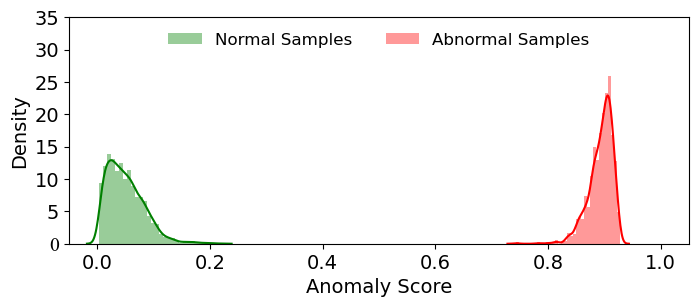

In [7]:
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
import seaborn as sns

figure = plt.figure(2,figsize=(8,3), dpi=100)
sns.distplot(pd.concat([TN, FP]).values[:,0],label='Normal Samples',color='g')
sns.distplot(pd.concat([TP, FN]).values[:,0],label='Abnormal Samples',color='r')
plt.xlabel('Anomaly Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.ylim([0, 35])
plt.xlim([-0.05,1.05])
plt.yticks(fontproperties = 'Times New Roman', fontsize = 14)
plt.xticks(fontproperties = 'Times New Roman', fontsize = 14)
plt.legend(fontsize=12, ncol=2,loc='upper center', frameon=False)
plt.show()
figure.savefig(r'.\figure\anomaly_score_distribution.pdf',bbox_inches = 'tight')

### Reconstruct overall feature

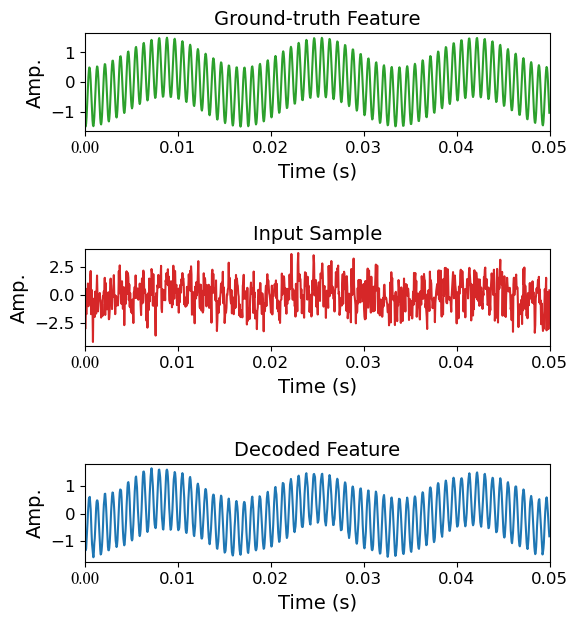

In [8]:
selected_samaple = 100

color_list = ['#2ca02c', '#d62728', '#1f77b4']

title_list = ['Ground-truth Feature', 'Input Sample', 'Decoded Feature']
simulated_signal = [data_dict['test_gth_1d'], data_dict['test_1d'], x_hat.cpu().detach().numpy()]

x = np.arange(0, 1024/20480, 1/20480)
figure = plt.figure(3,figsize=(6,7), dpi=100)
plt.subplots_adjust(hspace=1.2, wspace=0.3)
for i, signal in enumerate(simulated_signal):
    plt.subplot(3,1,i+1)
    plt.plot(x, signal[selected_samaple].flatten(), color=color_list[i])
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Amp.', fontsize=14)
    plt.yticks(fontproperties = 'Times New Roman', fontsize = 12)
    plt.xticks(fontproperties = 'Times New Roman', fontsize = 12)
    plt.xlim([0, 0.05])
    plt.title(title_list[i], fontsize=14)
plt.show()
figure.savefig(r'.\figure\reconstruct_overall_feature.pdf',bbox_inches = 'tight')

### Visualize atom feature

In [9]:
from tools.CalConvDict import GenConvDict

ParaDict = torch.load(generator_path, map_location='cpu')
MatrixName = ['W1','W2','W3','W4']
Dict = GenConvDict(opt, ParaDict, MatrixName)
ConvMatrix, SigLengthList = Dict.GenConvMatrix()
KernelLength, StrideLength = Dict.CalKernelLen()
D1, D2, D3, D4 = ConvMatrix['W1'], ConvMatrix['W2'], ConvMatrix['W3'], ConvMatrix['W4']
D12 = D1.dot(D2)
D123 = D12.dot(D3)
D1234 = D123.dot(D4)

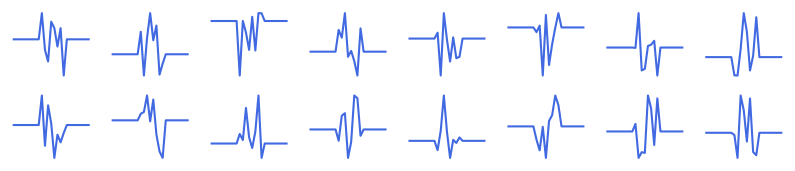

In [10]:
# visualize D1
import matplotlib.pyplot as plt
plt.subplots(figsize=(10, 2), dpi=100)
cols_skip = D1.shape[1]//opt.CL[0]
cols_loca = cols_skip//2
for i in range(16):
    ax = plt.subplot(2,8,i+1)
    ax.plot(D1[512-11:512+14,i*cols_skip+cols_loca],'royalblue',linewidth=1.5)
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.show()

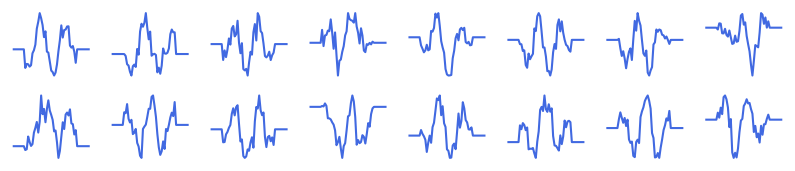

In [11]:
# visualize D12
import matplotlib.pyplot as plt
fig = plt.subplots(figsize=(10, 2), dpi=100)
cols_skip = D12.shape[1]//opt.CL[1]
cols_loca = cols_skip//2
for i in range(16):
    ax = plt.subplot(2,8,i+1)
    plt.plot(D12[512-18:512+35,i*cols_skip+cols_loca], 'royalblue',linewidth=1.5)
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.show()

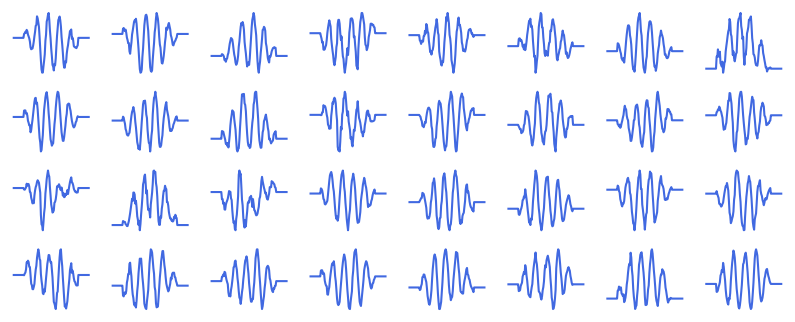

In [12]:
# visualize D123
import matplotlib.pyplot as plt
plt.subplots(figsize=(10, 4), dpi=100)
cols_skip = D123.shape[1]//opt.CL[2]
cols_loca = cols_skip//2
for i in range(32):
    ax = plt.subplot(4,8,i+1)
    plt.plot(D123[512-42:512+75,i*cols_skip+cols_loca], 'royalblue',linewidth=1.5)
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.show()

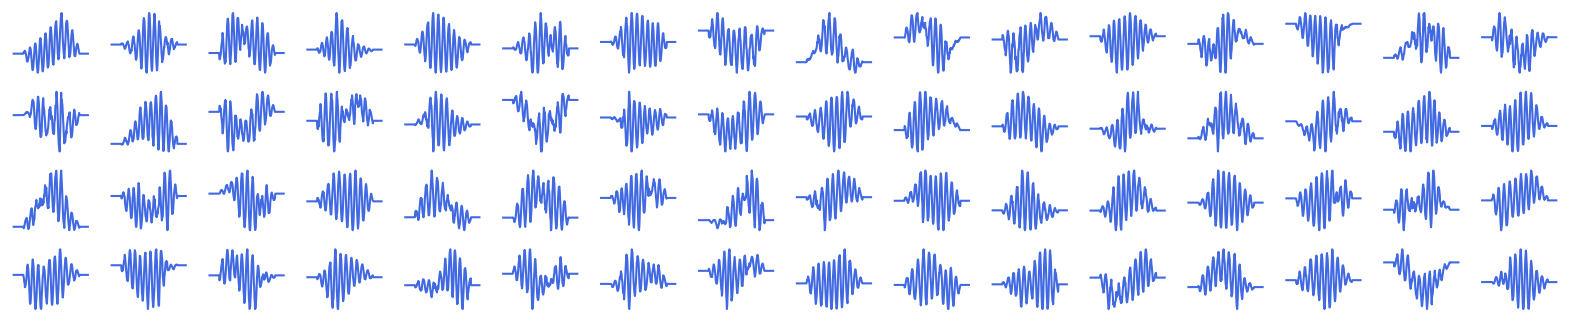

In [13]:
# visualize D1234
import matplotlib.pyplot as plt
plt.subplots(figsize=(20, 4), dpi=100)
cols_skip = D1234.shape[1]//opt.CL[3]
cols_loca = cols_skip//2
for i in range(64):
    ax = plt.subplot(4,16,i+1)
    plt.plot(D1234[512-90:512+150,i*cols_skip+cols_loca], 'royalblue',linewidth=1.5)
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.show()

# 3.  Ablation study

In [14]:
import joblib
import torch
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from tools.classify_result import classify_result
from tools.get_best_model import get_best_model
from model.AAU_Net import UnrolledAutoEncoder, Discriminator, parse_args

# dataset_list = ['Simulated', 'QianPeng', 'SQI']
# active_list = ['Hard', 'ReLU', 'Soft']
# detection_result = {dataset:[] for dataset in dataset_list}
# reconstruction_result = {}

# opt = parse_args()
# opt.use_cuda = False
# opt.Tensor = torch.FloatTensor

# for dataset in dataset_list:
#     opt.data_path = r'.\data\{}_dataset.pkl'.format(dataset)
#     data_dict = joblib.load(opt.data_path)
    
#     for active_type in active_list:
#         opt.active_type = active_type
#         opt.output_path = r'.\result\{}_{}'.format(dataset, active_type)
#         print('processing '+opt.output_path)
        
#         generator = UnrolledAutoEncoder(opt)
#         discriminator = Discriminator(opt)
#         generator.load_state_dict(torch.load(get_best_model(opt.output_path)['Generator'],map_location='cpu'))
#         discriminator.load_state_dict(torch.load(get_best_model(opt.output_path)['Discrim'],map_location='cpu'))
        
#         input_x = torch.Tensor(data_dict['test_1d'])
#         input_y = data_dict['test_label']

#         x_hat, x_z = generator(input_x, test=True)
#         score = discriminator(x_z)
#         result = score.cpu().detach().numpy()
#         RI, TP, TN, FP, FN = classify_result(result, input_y, thres=0.5, print_result=False)
        
        
#         TPR = len(TP)/(len(TP)+len(FN)); FPR = len(FP)/(len(FP)+len(TN)); ACC = len(RI)/(len(RI)+len(FP)+len(FN))
#         result = pd.concat([RI, FP, FN]).values[:,0]
#         fpr, tpr, threshold = metrics.roc_curve(input_y, result)
#         AUC = metrics.auc(fpr, tpr)
#         F1_score = metrics.f1_score(input_y, np.round(result))
        
#         detection_result[dataset].append([TPR, 1-FPR, ACC, AUC, F1_score])
#         if dataset=='Simulated':
#             gth = torch.Tensor(data_dict['test_gth_1d'])
#             reconstruction_result.update({active_type:torch.sqrt(torch.mean((gth[:2000]-x_hat[:2000])**2, axis=[1,2])).cpu().detach().numpy()})

# joblib.dump(detection_result, r'.\data\detection_result.pkl')
# joblib.dump(reconstruction_result, r'.\data\reconstruction_result.pkl')

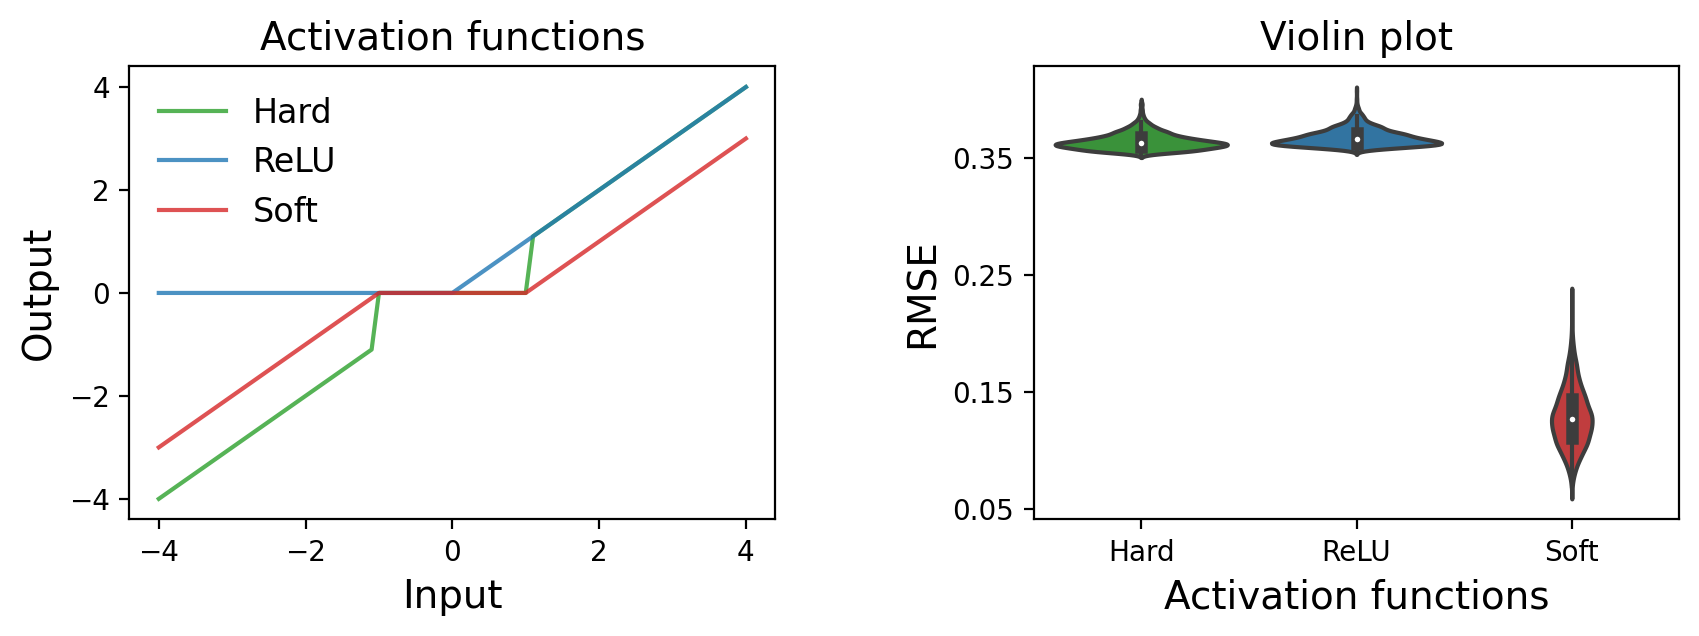

In [15]:
import torch
from model.AAU_Net import ReLU, Soft, Hard
x = torch.Tensor(np.arange(-4, 4.1, 0.1))
thres = 1
relu = ReLU(1, 0); soft = Soft(1, thres); hard = Hard(1, thres)
y_list = [hard(x).flatten(), relu(x).flatten(), soft(x).flatten()]

reconstruction_result = joblib.load(r'.\data\reconstruction_result.pkl')
my_pal = {"Hard": "#2ca02c", "ReLU": "#1f77b4", "Soft": "#d62728"}
color_list = ['#2ca02c', '#1f77b4', '#d62728']
RMSE_pd = pd.DataFrame(reconstruction_result)
RMSE_data = pd.concat([RMSE_pd['Hard'], RMSE_pd['ReLU'], RMSE_pd['Soft']], axis=0, ignore_index =True)
RMSE_data = pd.DataFrame(RMSE_data)
method = list(RMSE_pd.columns)
RMSE_data['Activation functions'] = pd.DataFrame({'Activation functions':[method[i//2000] for i in range(6000)]})
RMSE_data.rename(columns={0: 'RMSE'}, inplace=True)

figure = plt.figure(5,figsize=(10,3), dpi=200)
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.subplot(1,2,1)
for i, y in enumerate(y_list):
    plt.plot(x, y.detach().numpy(), linewidth=1.5, label=['Hard', 'ReLU', 'Soft'][i], color=color_list[i], alpha=0.8)
plt.xlabel('Input', fontsize=14)
plt.ylabel('Output', fontsize=14)
plt.legend(frameon=False, loc='upper left', ncol=1, fontsize=12)
plt.title('Activation functions', fontsize=14)

axes = plt.subplot(1,2,2)
sns.violinplot(x=RMSE_data['Activation functions'], y=RMSE_data['RMSE'], inner='box', palette=my_pal)
axes.set_title('Violin plot', fontsize=14)
axes.set_xlabel('Activation functions',fontsize=14)
axes.set_ylabel('RMSE',fontsize=14)
y_ticks = np.arange(0.05, 0.45, 0.1)
plt.yticks(y_ticks)

plt.show()
figure.savefig(r'.\figure\ablation_study_RMSE.pdf',bbox_inches = 'tight')

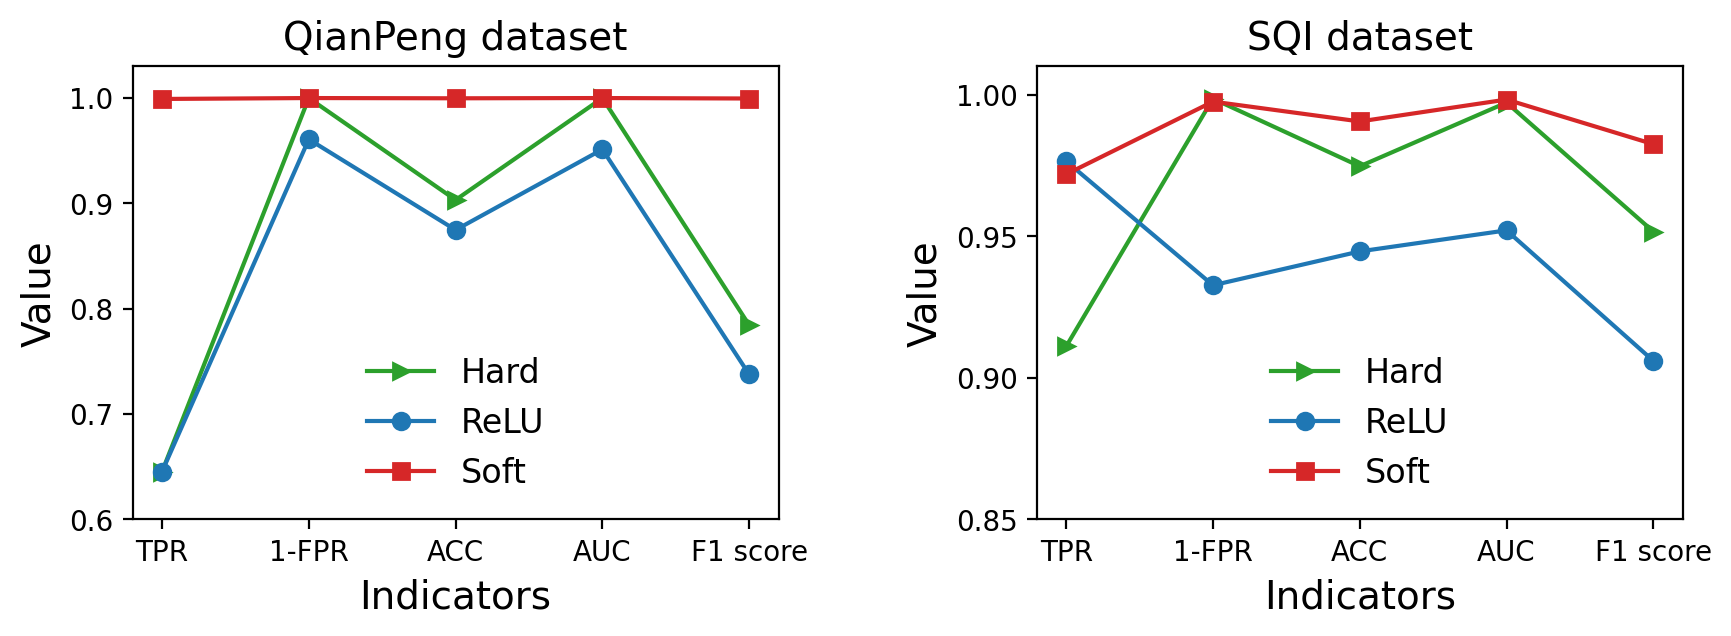

In [16]:
detection_result = joblib.load(r'.\data\detection_result.pkl')
color_list = ['#2ca02c', '#1f77b4', '#d62728']
marker_list = ['>', 'o', 's']
x = ['TPR', '1-FPR', 'ACC', 'AUC', 'F1 score']

figure = plt.figure(6,figsize=(10,3), dpi=200)
plt.subplots_adjust(hspace=0.5, wspace=0.4)
for i, dataset in enumerate(['QianPeng', 'SQI']):
    plt.subplot(1,2,i+1)
    result_array = np.array(detection_result[dataset])
    for j, active_type in enumerate(['Hard', 'ReLU', 'Soft']):
        plt.plot(x, result_array[j,:], color=color_list[j], label=active_type, linewidth=1.5, marker=marker_list[j])
    plt.ylim([0.6, 1.03] if i==0 else [0.86, 1.01])
    plt.xlabel('Indicators', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.title(dataset+' dataset', fontsize=14)
    plt.legend(frameon=False, loc='lower center', ncol=1, fontsize=12)
    y_ticks = np.arange(0.85, 1.01, 0.05) if i==1 else np.arange(0.6, 1.04, 0.1)
    plt.yticks(y_ticks)
plt.show()
figure.savefig(r'.\figure\ablation_study_Indicators.pdf',bbox_inches = 'tight')